# Fun with A326344

Sequence [A326344](https://oeis.org/A326344) in the OEIS is very interesting. In this notebook I will gather some thoughts, proofs, and code about it and its various generalizations.

## Definitions

Let $b_n(k)$ be the "base-$n$ generalization" of A326344. Its exact definition is in given in [A327701](https://oeis.org/A327701).

The basic question about $b_n(k)$ is this:

>Is $b_n(k)$ bounded in $k$ for all $n$? If so, what are these bounds?

For example, we know that $b_{10}(k) \leq 909$, and that $909$ is obtained. The known maxima are [A327701](https://oeis.org/A327701).

Before getting into anymore details, let's see some data.

## Utility functions

In [1]:
from sympy import isprime, nextprime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

def nextcompo(n):
    n += 1
    while isprime(n) or n == 1:
        n += 1

    return n


def num_to_digits(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]


def digits_to_num(digits, b):
    return sum(b**k * d for k, d in enumerate(digits[::-1]))


def backwards_base(n, b):
    return digits_to_num(num_to_digits(n, b)[::-1], b)

In [2]:
def base_b_seq(n, b=10, last_k=None, term=1):
    """
    Compute b_n(k) as given in A327701.

    Basic usage is base_b_seq(n, b), where n is the number of terms and b is the base.

    Optional parameters are `term` and `last_k`, to allow for picking up the computation
    at a later point (or modifying the original sequence).

    Returns a list.
    """
    if last_k is None:
        # We ignore `term` in this case.
        term = 1
        terms = [term]
        last_k = 1
    else:
        terms = []

    for k in range(last_k + 1, n + 1):
        if isprime(k):
            next = nextprime(term)
        else:
            next = nextcompo(term)

        term = backwards_base(next, b)
        terms.append(term)
        n -= 1

    return terms

## Data

In [3]:
base_b_seq(20, 10) # Compare with https://oeis.org/A326344.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 4, 5, 6, 8, 9, 11, 21, 32, 33]

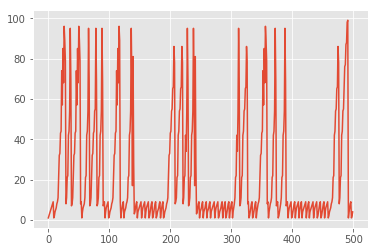

In [4]:
plt.plot(base_b_seq(500, 10))

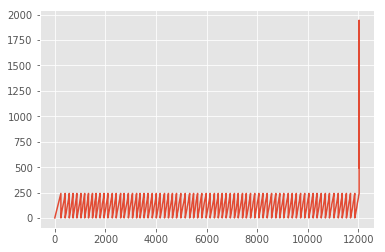

In [5]:
plt.plot(base_b_seq(12038, 243))

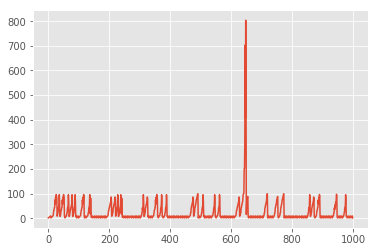

In [6]:
plt.plot(base_b_seq(1000, 10))

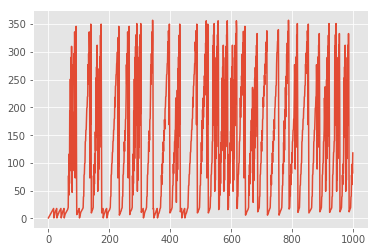

In [7]:
plt.plot(base_b_seq(1000, 19))

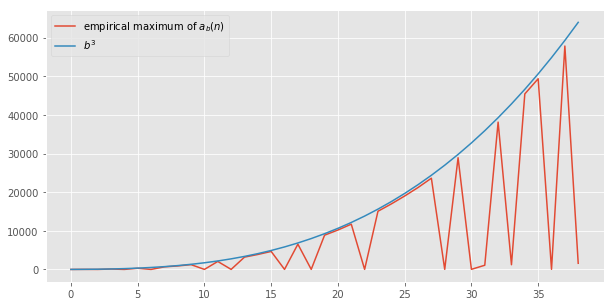

In [8]:
from sympy import prevprime

# Maximum of b_k(n) out to a moderately large n.
max_base = 40
maxima = [(k, max(base_b_seq(50000, k))) for k in range(2, max_base + 1)]

# Maximum looks suspiciously like k^3.
plt.figure(figsize=(10, 5))
plt.plot([maximum for _, maximum in maxima], label=r"empirical maximum of $a_b(n)$")
plt.plot([k**3 for k in range(2, max_base + 1)], label=r"$b^3$")
[(k, prevprime(k**3), max) for k, max in maxima[1:]]
plt.legend()

# Conjectures

Let $a(n) = \max_k b_n(k)$, if such a maximum exists.

1. (Mine) $a(n) <= n^3$ for all $n$. (Maybe even $\limsup_n a(n) / n^3 = 1$, if I'm feeling bold.)
2. (Neil Sloane) $a(n) = n - 1$ iff $n - 1$ is $1$ or an odd prime.

## What we know

Neil's conjecture is (at least) two-thirds of the way correct.

**Proposition.** $a(n) = n - 1$ if $n - 1$ is $1$ or an odd prime.

This is half of Neil's conjecture.

**Proof.** The case $n = 2$ is easy to check, so suppose that $n - 1$ is an odd prime. Note that $n$ must be composite. Suppose that $b_n(j) < n$ for all $j \leq k$. If $b_n(k) < n - 1$, then both the next composite and the next prime after $b_n(k)$ are $\leq n$. Therefore, no matter what $k + 1$ is, $b_n(k + 1)$ remains in "single digits" in base $n$. If $b_n(k) = n - 1$, then since the sequence has been in single digits up to $k$, the only way for this to happen is by $k$ itself being prime. Then $k + 1$ is composite, so $b_n(k + 1) = 1$. Since $b_n(k)$ begins in single digits, it follows that it always remains in single digits, i.e., $b_n(k) < n$. $\blacksquare$

(*Note*: I ignored the possibility that $k = 2$ in the above proof. I should fix that, though I'm not worried about it.)

**Proposition.** $b_n(k) > n$ for some $k$ if $n-1$ is composite and $n$ is prime.

This is half of the *inverse* of Neil's conjecture.

**Proof.** It suffices to show that there exists a sequence of consecutive, composite integers of length $> n$. Then, even if $b_n(k) = 1$, a string of "next composite" cases of this length will force $b_n$ to skip over the prime $n$ and achieve $n + 1$. We can find arbitrarily large gaps between primes, so we're done. $\blacksquare$

It remains to show this: If both $n-1$ and $n$ are composite, then $b_n(k)$ eventually exceeds $n - 1$. The argument here is not so clear. It begins like this:

If both $n$ and $n - 1$ are composite, then the only way to break out of single digits is to ask for the next prime when $b_n(k) \geq p^*$, where $p^*$ is the greatest prime less than $n$.

Given the above remarks, to prove $b_n(k) \leq n^3$ it would suffice to prove it when $n - 1$ is composite. If $n - 1$ is prime, then $b_n(k) \leq n - 1 < n^3$ for $n \geq 1$.

# The bounds

We basically have one algorithm to provide provide upper bounds for $b_k(n)$ for any $k$, then two varients of it. We do not know if they work for all $k$, nor do we know if any of them are guaranteed to provide a sharp upper bound when they do work. I call the general algorithm the *tree* bound, and the two varients the the *Sigrist* and *Weimholt* bounds, after the two who presented them in A326344. All methods can be automated. The Weimholt bound won in A326344, but the Sigrist bound has proven more successful in cases when $b_n(k)$ is bounded by $n - 1$.

For an explanation of the bounds, see my article [Fun with A326344](rwdb.xyz/fun-with-a326344).

## The tree bound

In [11]:
from sympy import factorint

def is_possible_prime_val(n, m):
    """Return true if x mod m = n does not rule out x prime."""
    m_factors = set(factorint(m).keys())
    n_factors = set(factorint(n).keys())

    return len(n_factors & m_factors) == 0


def find_possible_prime_vals(m):
    return set(k for k in range(m) if is_possible_prime_val(k, m)) - {0}


def generate_tree_terms(residue, initial, b, p, c, modulus):
    """
    Compute a set of terms which could possibly appear in a sequence a(n) defined
    by the rules

        - a(n) = p(a(n - 1)) if n is prime;
        - a(n) = c(a(n - 1)) if n is composite,

    if the sequence starts at a(n) = `initial` where n mod `modulus` = residue.

    :residue: Initial residue class.
    :initial: Initial value of the sequence.
    :b: Base of the sequence.
    :modulus: Modulus for the modulus argument.
    """

    possible_prime_mods = find_possible_prime_vals(modulus)

    # Contains (n mod modulus, value) pairs.
    seen = set()
    # Contains (n mod, value) pairs.
    to_visit = [(residue % modulus, initial)]

    while to_visit:
        mod, term = to_visit.pop()

        if (mod, term) in seen:
            continue

        seen.update({(mod, term)})
        next_mod = (mod + 1) % modulus

        next_comp = c(term)
        if (next_mod, next_comp) not in seen:
            to_visit.append((next_mod, next_comp))

        if next_mod in possible_prime_mods:
            next_prime = p(term)
            if (next_mod, next_prime) not in seen:
                to_visit.append((next_mod, next_prime))

    return seen


def generate_tree_reversal_terms(residue, initial, base, modulus):
    p = lambda n: backwards_base(nextprime(n), base)
    c = lambda n: backwards_base(nextcompo(n), base)
    return generate_tree_terms(residue, initial, base, p, c, modulus)

def tree_bound(base, modulus):
    initial_terms = base_b_seq(modulus + 1, base)
    tree_term = initial_terms[-1]
    tree_vals = generate_tree_reversal_terms(1, tree_term, base, modulus)
    tree_max = max(val for _, val in tree_vals)
    return max(tree_max, max(initial_terms))

In [12]:
tree_bound(10, 2)

939

In [13]:
tree_bound(10, 6)

909

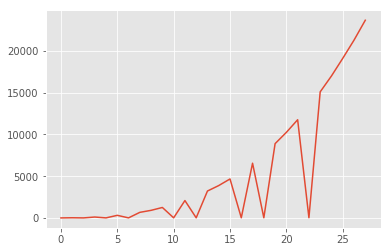

In [29]:
tree_bounds = [tree_bound(b, 30) for b in range(2, 30)]
plt.plot(bounds)
plt.show()

## Sigrist's bound

This is basically the above method with `modulus = 2`.

In [14]:
def generate_terms(a0, p, c):
    """
    Compute a containing set for the terms of a sequence a(n)
    where a(n) = c(a(n - 1)) if n is even, and a(n) is in
    {p(a(n - 1)), c(a(n - 1))} if n is odd.
    """
    terms = {a0}

    while True:
        new_terms = (terms
                      | set(map(c, map(p, terms)))
                      | set(map(c, map(c, terms))))

        if new_terms != terms:
            terms = new_terms
        else:
            break
    even_terms = terms
    odd_terms = set(map(p, even_terms)) | set(map(c, even_terms))
    return even_terms, odd_terms

def base_b_terms(b):
    p = lambda n: backwards_base(nextprime(n), b)
    c = lambda n: backwards_base(nextcompo(n), b)

    evens, odds = generate_terms(2, p, c)
    return evens, odds

def sigrist_bound(b):
    evens, odds = base_b_terms(b)
    return max(evens | odds)

In [15]:
sigrist_bound(10)

939

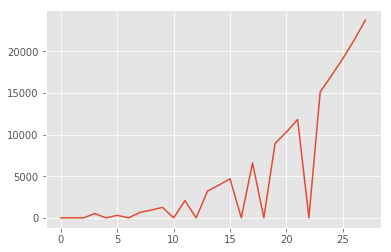

In [30]:
sigrist_bounds = [sigrist_bound(b) for b in range(2, 30)]
plt.plot(sigrist_bounds)
plt.show()

## Weimholt's bound

This is a slight modification of the tree bound which tries to get more granular information about when the sequence could break out of single digits.

In [31]:
from sympy import prime, factorint

def find_single_breakouts(b):
    """
    Find the numbers and paths to numbers which result in more than 1 digit.
    """

    breakouts = []

    for k in range(1, b):
        next_comp_case = backwards_base(nextcompo(k), b)
        next_prime_case = backwards_base(nextprime(k), b)

        if next_comp_case >= b:
            breakouts.append((next_comp_case, "comp"))
        if next_prime_case >= b:
            breakouts.append((next_prime_case, "prime"))

    return set(breakouts)


def escape_trees(b, modulus):
    breakouts = find_single_breakouts(b)

    possible_prime_vals = find_possible_prime_vals(modulus)
    definite_composite_vals = set(range(modulus)) - possible_prime_vals

    ensemble = []

    for term, state in breakouts:
        if state == "prime":
            trees = [generate_tree_reversal_terms(m, term, b, modulus) for m in possible_prime_vals]
        else:
            trees = [generate_tree_reversal_terms(m, term, b, modulus) for m in definite_composite_vals]

        ensemble.append(trees)
    return [tree for trees in ensemble for tree in trees]


def weimholt_bound(b, modulus):
    trees = escape_trees(b, modulus)
    tree_max = [max([term for _, term in tree]) for tree in trees]
    return max(tree_max)

In [32]:
weimholt_bound(10, 6)

909

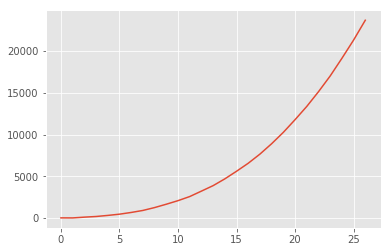

In [35]:
weimholt_bounds = [weimholt_bound(b, 6) for b in range(3, 30)]
plt.plot(weimholt_bounds)
plt.show()

## Refinement of bounds

In [ ]:
from tqdm import tqdm_notebook as tqdm

good = []
bad = []

start_power = 3
max_power = 5

for base in tqdm(range(3, 31)):
    terms = []
    last_term = None
    last_limit = None
    done = False

    print("base:", base)
    for power in range(start_power, max_power + 1):
        print("trying up to 5 * 10**{}".format(power))
        limit = 5 * 10**power
        new_terms = _base_b_seq(limit, base, last_term, last_limit)
        terms += new_terms
        last_term = new_terms[-1]
        last_limit = limit

        observed_max = max(terms)
        wb, sb = weimholt_bound(base, 3), sigrist_bound(base)
        if observed_max in [wb, sb]:
            good.append((base, observed_max))
            done = True
            break

    if not done:
        bad.append((base, wb, sb, observed_max))

## Experimental automatic tree generation

In [36]:
from treelib import Node, Tree

def weimholt_tree_treelib(n, start, b):
    tree = Tree()

    # Contains (term, n mod 6, parent_id) tuples.
    to_visit = [(n % 30, start, None)]
    seen = set()
    next_id = 0

    while to_visit:
        mod, term, parent_id = to_visit.pop()

        if (mod, term) in seen:
            tree.create_node((mod, "[" + str(term) + "]"), next_id, parent=parent_id)
            next_id += 1
            continue

        tree.create_node((mod, str(term)), next_id, parent=parent_id)
        next_id += 1
        seen.update({(mod, term)})
        next_mod = (mod + 1) % 30

        next_comp = backwards_base(nextcompo(term), b)
        to_visit.append((next_mod, next_comp, next_id - 1))

        if next_mod in [1, 7, 11, 13, 17, 19, 23, 27, 29]:
            next_prime = backwards_base(nextprime(term), b)
            to_visit.append((next_mod, next_prime, next_id - 1))

    return tree

def treelib_escape_trees(b):
    breakouts = find_single_breakouts(b)

    ensemble = []

    for term, state in breakouts:
        if state == "prime":
            trees = [weimholt_tree_treelib(m, term, b) for m in [-1, 1]]
        else:
            trees = [weimholt_tree_treelib(m, term, b) for m in [0, 2, 3, 4]]

        ensemble.append(trees)

    return [tree for trees in ensemble for tree in trees]

for tree in treelib_escape_trees(10):
    tree.show()

(29, '11')
└── (0, '21')
    ├── (1, '22')
    │   └── (2, '42')
    │       └── (3, '44')
    │           └── (4, '54')
    │               └── (5, '55')
    │                   └── (6, '65')
    │                       ├── (7, '66')
    │                       │   └── (8, '[86]')
    │                       └── (7, '[76]')
    └── (1, '32')
        └── (2, '33')
            └── (3, '43')
                └── (4, '44')
                    └── (5, '54')
                        └── (6, '55')
                            ├── (7, '65')
                            │   └── (8, '66')
                            │       └── (9, '[86]')
                            └── (7, '95')
                                └── (8, '69')
                                    └── (9, '7')
                                        └── (10, '8')
                                            ├── (11, '11')
                                            │   └── (12, '21')
                                            │       